In [24]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torchvision
from torchvision import datasets,transforms
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if(torch.cuda.is_available()):
  print("The device is " + torch.cuda.get_device_name())
else:
    print("Using cpu no gpu available")
print('\n',device)

The device is GeForce 940MX

 cuda:0


In [5]:
train = datasets.MNIST("",train = True ,download =  True, transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.1307, ), (0.3081, ))]))
test = datasets.MNIST("",train = False ,download = True, transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.1307, ), (0.3081, ))]))

0.0%

100.0%


Extracting MNIST\raw\train-images-idx3-ubyte.gz to MNIST\raw



102.8%


Extracting MNIST\raw\train-labels-idx1-ubyte.gz to MNIST\raw



100.0%


Extracting MNIST\raw\t10k-images-idx3-ubyte.gz to MNIST\raw



22.5%

112.7%

Extracting MNIST\raw\t10k-labels-idx1-ubyte.gz to MNIST\raw




C:\Users\leleg\anaconda3\envs\pytorchml\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [6]:
dtype = torch.float32

In [7]:
from torch.utils.data import random_split,DataLoader
train,val = random_split(train, [55000,5000])
train_loader = DataLoader(train,batch_size = 64)
val_loader = DataLoader(val,batch_size = 64)


In [8]:
test_loader = DataLoader(test,batch_size = 64)

In [9]:
for (x,y) in train_loader:
    print(x.shape,y.shape)
    break

torch.Size([64, 1, 28, 28]) torch.Size([64])


In [10]:
def flatten(x):
    N = x.shape[0] # read in N, C, H, W
    return x.view(N, -1)  # "flatten" the C * H * W values into a single vector per image

In [11]:
print_every = 200

In [12]:
metric = nn.CrossEntropyLoss()

In [13]:
class skipper(nn.Module):
    def __init__(self,width):
        super(skipper,self).__init__()
        #making a res block using sequential inside module hehe
        self.resb1 = nn.Sequential(
        nn.Conv2d(in_channels = width[0] , 
                  out_channels = width[1], 
                  kernel_size= (3,3),
                  stride = (1,1),
                  padding = 'same',
                  bias = True
                 ),
        nn.BatchNorm2d(width[1]),
        nn.ReLU(),
        nn.Conv2d(in_channels = width[1],
                  out_channels = width[2],
                  kernel_size = (3,3),
                  stride = (1,1),
                  padding = 'same',
                  bias = True
                 ),
        nn.BatchNorm2d(width[2]),
        nn.MaxPool2d(kernel_size = (2,2),stride = (2,2),padding = 0)
                  
        )
        self.skip = nn.Sequential(
        nn.Conv2d(in_channels = width[0],
                  out_channels = width[2],
                  kernel_size = (1,1),
                  padding = 'same',
                  bias = True
                 ),
        nn.BatchNorm2d(width[2]),
        nn.MaxPool2d(kernel_size = (2,2),stride = (2,2),padding = 0)
        )
    def forward(self,x):
        #cut = x
        out1 = self.resb1(x)
        #print(out1.shape)
        out2 = self.skip(x)
        x = F.relu(out1+out2)
        return x
        
        

In [14]:
class network(nn.Module):
    def __init__(self):
        super(network,self).__init__()
        self.block1 =  skipper(width= [1,16,32])
        #self.reduce = nn.MaxPool2d(kernel_size = (2,2),stride = (2,2),padding = 0)
        self.block2 =  skipper(width= [32,64,128])
        self.fc1    =  nn.Linear(128*7*7,200)
        self.fc2    =  nn.Linear(200,10)
        #self.bn1    =  nn.BatchNorm1d(200)
        
    def forward(self,x):
        out = self.block1(x)
        #print(out.shape)
        #out = self.reduce(out)
        out = self.block2(out)
        #out = self.reduce(out)
        out = flatten(out)
        out = self.fc1(out)
        out = F.relu(out)
        #out = self.bn1(out)
        score = self.fc2(out)
        return score

In [15]:
def check_accuracy_part(loader, model):
    num_correct = 0
    num_samples = 0
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)
            scores = model(x)
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
        acc = float(num_correct) / num_samples
        print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))

In [16]:
def train_part(model, optimizer,scheduler_f, epochs=1):
    losses =[]
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    for e in range(epochs):
        avg = 0
        i = 0
        for t, (x, y) in enumerate(train_loader):
            model.train()  # put model to training mode
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)

            scores = model(x)
            #scores = scores.reshape(y.shape[1])
            #print(scores.shape,x.shape,y.shape)
            #break
            loss = metric(scores, y)
           

            optimizer.zero_grad()

        
            loss.backward()
             
        
            optimizer.step()
            #scheduler_f.step()
            avg+=float(loss)
            i+=1

            if t % print_every == 0:
                print('Iteration %d, loss = %.4f' % (t, loss.item()))
                check_accuracy_part(val_loader, model)
                print()
        scheduler_f.step()
        print('Epoch-{0} lr: {1}'.format(e, optimizer.param_groups[0]['lr']))
        losses.append(avg/i)
    return losses
        #break
                     

In [17]:
learning_rate = 1e-3
model = network()
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(),lr = learning_rate)
scheduler = optim.lr_scheduler.StepLR(optimizer,step_size = 3,gamma = 0.3)
print("Summary of the layers of the model : \n\n")
summary(model, input_size=(1, 28, 28))

Summary of the layers of the model : 


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             160
       BatchNorm2d-2           [-1, 16, 28, 28]              32
              ReLU-3           [-1, 16, 28, 28]               0
            Conv2d-4           [-1, 32, 28, 28]           4,640
       BatchNorm2d-5           [-1, 32, 28, 28]              64
         MaxPool2d-6           [-1, 32, 14, 14]               0
            Conv2d-7           [-1, 32, 28, 28]              64
       BatchNorm2d-8           [-1, 32, 28, 28]              64
         MaxPool2d-9           [-1, 32, 14, 14]               0
          skipper-10           [-1, 32, 14, 14]               0
           Conv2d-11           [-1, 64, 14, 14]          18,496
      BatchNorm2d-12           [-1, 64, 14, 14]             128
             ReLU-13           [-1, 64, 14, 14]               0

In [18]:
losses = train_part(model, optimizer,scheduler_f = scheduler,epochs = 10)

Iteration 0, loss = 2.3465
Got 480 / 5000 correct (9.60)

Iteration 200, loss = 0.0364
Got 4816 / 5000 correct (96.32)

Iteration 400, loss = 0.0735
Got 4803 / 5000 correct (96.06)

Iteration 600, loss = 0.1304
Got 4853 / 5000 correct (97.06)

Iteration 800, loss = 0.0901
Got 4871 / 5000 correct (97.42)

Epoch-0 lr: 0.001
Iteration 0, loss = 0.0138
Got 4892 / 5000 correct (97.84)

Iteration 200, loss = 0.0030
Got 4922 / 5000 correct (98.44)

Iteration 400, loss = 0.0527
Got 4901 / 5000 correct (98.02)

Iteration 600, loss = 0.1298
Got 4898 / 5000 correct (97.96)

Iteration 800, loss = 0.0564
Got 4930 / 5000 correct (98.60)

Epoch-1 lr: 0.001
Iteration 0, loss = 0.0092
Got 4913 / 5000 correct (98.26)

Iteration 200, loss = 0.0010
Got 4921 / 5000 correct (98.42)

Iteration 400, loss = 0.0431
Got 4911 / 5000 correct (98.22)

Iteration 600, loss = 0.0824
Got 4943 / 5000 correct (98.86)

Iteration 800, loss = 0.0051
Got 4942 / 5000 correct (98.84)

Epoch-2 lr: 0.0003
Iteration 0, loss = 0.0

Cost v/s Epochs


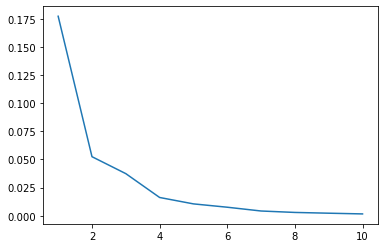

In [27]:
plt.plot(a,losses)
print("Cost v/s Epochs")
plt.show()


In [19]:
print("The training accuracy is : \n")
check_accuracy_part(train_loader,model)
print("The validation accuracy is : \n")
check_accuracy_part(val_loader,model)
print("The testing accuracy is : \n")
check_accuracy_part(test_loader,model)

The training accuracy is : 

Got 54989 / 55000 correct (99.98)
The validation accuracy is : 

Got 4969 / 5000 correct (99.38)
The testing accuracy is : 

Got 9929 / 10000 correct (99.29)
